In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.metrics as K
import tarfile
import pandas as pd
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU

In [2]:
path_to_tar_file = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
output_directory = "brats21-dataset-training-validation"

# Open the tar file in read mode
with tarfile.open(path_to_tar_file, "r") as tar_ref:
    # Extract all contents to the specified directory
    tar_ref.extractall(output_directory)

print(f"Extraction completed. Files are saved to {output_directory}")

Extraction completed. Files are saved to brats21-dataset-training-validation


In [3]:
VOLUME_START_AT = 60
VOLUME_SLICES = 85

In [4]:
data_path = "/kaggle/working/brats21-dataset-training-validation"
samples = [f for f in os.listdir(data_path) if not f.startswith('.')]
print("Number of samples:", len(samples))

Number of samples: 1251


In [5]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 850
Validation length: 251
Test length: 150


In [6]:
def add_noise(images, noise_type="gaussian", mean=0, std=0.1):
    """
    Adds noise to the input images.
    
    :param images: Input image batch (numpy array), shape (batch_size, height, width, channels)
    :param noise_type: Type of noise ('gaussian', 'rician')
    :param mean: Mean for Gaussian noise
    :param std: Standard deviation for the noise
    :return: Noisy images
    """
    images = images.astype(np.float32)
    
    # Normalize the images to [0, 1] range if they are not already
    # Only normalize if the max value is greater than zero
    if np.max(images) > 0:
        images = images / np.max(images)
    
    if noise_type == "gaussian":
        noise = np.random.normal(mean, std, images.shape)
        noisy_images = images + noise
        noisy_images = np.clip(noisy_images, 0, 1)  # Ensure values remain valid
    
    elif noise_type == "rician":
        # Add Gaussian noise to the real and imaginary parts
        noise_real = np.random.normal(mean, std, images.shape)
        noise_imag = np.random.normal(mean, std, images.shape)
        # Simulate the complex image with noise
        noisy_images = np.sqrt((images + noise_real) ** 2 + noise_imag ** 2)
        # Normalize to the original scale
        noisy_images = noisy_images / np.max(noisy_images) * np.max(images)
        noisy_images = np.clip(noisy_images, 0, 1)  # Ensure values remain valid

    else:
        # If an unknown noise_type is specified, return images unchanged
        noisy_images = images

    return noisy_images

In [7]:
def add_low_resolution(images, scale_factor=0.5):
    """
    Simulates low-resolution images by downscaling and then upscaling the input images.
    
    :param images: Input image batch (numpy array)
    :param scale_factor: Factor by which to downscale the image resolution
    :return: Low-resolution images
    """
    low_res_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        # Downscale
        h, w = images[i].shape[:2]
        downscaled = cv2.resize(images[i], (int(w * scale_factor), int(h * scale_factor)), interpolation=cv2.INTER_AREA)
        # Upscale back to original size
        low_res_images[i] = cv2.resize(downscaled, (w, h), interpolation=cv2.INTER_LINEAR)
    return low_res_images

In [8]:

from scipy.ndimage import rotate

def add_rotation(image, mask, angle_choices=[90, 180, 270]):
    """
    Rotate an image and its corresponding mask by a random angle from angle_choices.

    :param image: Input image (numpy array), shape (H, W, C)
    :param mask: Corresponding mask (numpy array), shape (H, W, num_classes)
    :param angle_choices: List of angles to choose from
    :return: Rotated image and mask
    """
    # Randomly select an angle
    angle = random.choice(angle_choices)
    
    # Rotate the image
    rotated_image = rotate(
        image, angle, axes=(0, 1), reshape=False, order=1, mode='nearest'
    )

    # Rotate the mask
    # Since masks have discrete labels, use order=0 (nearest-neighbor interpolation)
    rotated_mask = rotate(
        mask, angle, axes=(0, 1), reshape=False, order=0, mode='nearest'
    )
    
    return rotated_image, rotated_mask

In [9]:


IMG_SIZE = 128


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Call parent constructor
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_IDs))
        self.on_epoch_end()
        self.class_frequencies = np.zeros(4)

    def __len__(self):
        length = int(np.ceil(len(self.list_IDs) / self.batch_size))
        return length

    def __getitem__(self, index):
        # Generate indexes of the batch
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.list_IDs))
        indexes = self.indexes[start_index:end_index]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids, **kwargs):
        """
        Generates data for a batch of images and corresponding segmentation masks.
        """
        # Initialize arrays for the inputs and labels
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4), dtype=np.float32)
    
        # Loop over the batch IDs
        for c, sample_id in enumerate(batch_ids):
            sample_path = os.path.join(data_path, sample_id, sample_id)
            t1ce_path = sample_path + '_t1ce.nii.gz'
            flair_path = sample_path + '_flair.nii.gz'
            seg_path = sample_path + '_seg.nii.gz'
            t1_path = sample_path + '_t1.nii.gz'
            t2_path = sample_path + '_t2.nii.gz'
    
            # Load the images using nibabel
            try:
                t1ce = nib.load(t1ce_path).get_fdata()
                flair = nib.load(flair_path).get_fdata()
                seg = nib.load(seg_path).get_fdata()
                t1 = nib.load(t1_path).get_fdata()
                t2 = nib.load(t2_path).get_fdata()
            except FileNotFoundError:
                print(f"Warning: Files for {sample_id} are missing or cannot be loaded.")
                continue
    
            # Z-score normalization per modality per volume
            modalities = {'flair': flair, 't1ce': t1ce, 't1': t1, 't2': t2}
            epsilon = 1e-8  # Small constant to prevent division by zero
            for modality_name, modality_data in modalities.items():
                # Compute mean and std for the non-zero voxels
                non_zero_voxels = modality_data[modality_data > 0]
                if non_zero_voxels.size > 0:
                    mean = np.mean(non_zero_voxels)
                    std = np.std(non_zero_voxels)
                else:
                    mean = 0.0
                    std = 1.0
                std = max(std, epsilon)  # Avoid division by zero
                # Normalize the data
                modality_data = (modality_data - mean) / std
                # Optionally clip the values to a range
                modality_data = np.clip(modality_data, -5, 5)
                # Update the modality in the dictionary
                modalities[modality_name] = modality_data
    
            # Assign the normalized modalities back to variables
            flair = modalities['flair']
            t1ce = modalities['t1ce']
            t1 = modalities['t1']
            t2 = modalities['t2']
    
            # Define the modalities_list here
            modalities_list = [flair, t1ce, t1, t2]
    
            # Process each slice in the volume
            for j in range(VOLUME_SLICES):
                slice_index = j + VOLUME_START_AT
                X_index = j + VOLUME_SLICES * c  # Current index in X and y arrays
    
                # Extract and resize image modalities
                X_slice = np.zeros((*self.dim, self.n_channels), dtype=np.float32)
                for channel in range(self.n_channels):
                    modality = modalities_list[channel]
                    X_slice[:, :, channel] = cv2.resize(
                        modality[:, :, slice_index],
                        self.dim,
                        interpolation=cv2.INTER_LINEAR
                    )
                X[X_index] = X_slice
    
                # Resize the segmentation mask
                seg_slice = seg[:, :, slice_index]
                seg_resized = cv2.resize(seg_slice, self.dim, interpolation=cv2.INTER_NEAREST)
                seg_resized = np.clip(seg_resized, 0, 3)
    
                # One-hot encode the segmentation mask
                y[X_index] = self.__one_hot_encoding(seg_resized)
    
                # Data augmentation
                augment_type = random.choices(
                    ["none", "rician", "low_res", "rotation", "rician_rotation", "low_res_rotation", "all"],
                    weights=[0.75, 0.05, 0.05, 0.05, 0.025, 0.025, 0.05], k=1
                )[0]
    
                if augment_type == "rician":
                    X[X_index] = add_noise(X[X_index:X_index+1], noise_type="rician", mean=0, std=0.05)[0]
                elif augment_type == "low_res":
                    X[X_index] = add_low_resolution(X[X_index:X_index+1], scale_factor=0.5)[0]
                elif augment_type == "rotation":
                    X[X_index], y[X_index] = add_rotation(X[X_index], y[X_index])
                elif augment_type == "rician_rotation":
                    # Apply Rician noise, then rotation
                    X_aug = add_noise(X[X_index:X_index+1], noise_type="rician", mean=0, std=0.05)[0]
                    X[X_index], y[X_index] = add_rotation(X_aug, y[X_index])
                elif augment_type == "low_res_rotation":
                    # Apply low resolution, then rotation
                    X_aug = add_low_resolution(X[X_index:X_index+1], scale_factor=0.5)[0]
                    X[X_index], y[X_index] = add_rotation(X_aug, y[X_index])
                elif augment_type == "all":
                    # Apply Rician noise, low resolution, then rotation
                    X_aug = add_noise(X[X_index:X_index+1], noise_type="rician", mean=0, std=0.05)
                    X_aug = add_low_resolution(X_aug, scale_factor=0.5)[0]
                    X[X_index], y[X_index] = add_rotation(X_aug, y[X_index])
    
        return X, y

    def __one_hot_encoding(self, mask, **kwargs):
        one_hot_mask = np.zeros((*self.dim, 4), dtype=np.float32)
        for i in range(4):
            one_hot_mask[:, :, i] = (mask == i).astype(np.float32)
        return one_hot_mask

    def repeat(self):
        while True:
            # Iterate over batches in the current epoch
            for index in range(len(self)):
                yield self.__getitem__(index)
            # At the end of the epoch, reset indexes and shuffle if necessary
            self.on_epoch_end()



training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)



In [10]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Input, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

def build_unet(inputs, ker_init, dropout):
    # Encoder
    # Block 1
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(dropout)(conv1)  # Added dropout
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(dropout)(conv2)  # Added dropout
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(dropout)(conv3)  # Added dropout
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(dropout)(conv4)  # Added dropout
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(dropout)(conv5)  # Dropout in bottleneck

    # Decoder
    # Up Block 1
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(256, 2, padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(up6)
    up6 = BatchNormalization()(up6)
    up6 = Activation('relu')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(dropout)(conv6)  # Added dropout

    # Up Block 2
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(up7)
    up7 = BatchNormalization()(up7)
    up7 = Activation('relu')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(dropout)(conv7)  # Added dropout

    # Up Block 3
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, padding='same', kernel_initializer=ker_init,
                 kernel_regularizer=regularizers.l2(0.0001))(up8)
    up8 = BatchNormalization()(up8)
    up8 = Activation('relu')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Dropout(dropout)(conv8)  # Added dropout

    # Up Block 4
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(32, 2, padding='same', kernel_initializer=ker_init,
                 kernel_regularizer=regularizers.l2(0.0001))(up9)
    up9 = BatchNormalization()(up9)
    up9 = Activation('relu')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Dropout(dropout)(conv9)  # Added dropout

    # Output Layer
    conv10 = Conv2D(4, 1, activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

In [11]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coef(num_classes):
    def _dice_coef(y_true, y_pred, smooth=1):
        """Dice coefficient per class averaged over all classes."""
        dice = []
        for i in range(num_classes):
            y_true_f = K.flatten(y_true[..., i])
            y_pred_f = K.flatten(y_pred[..., i])

            intersection = K.sum(y_true_f * y_pred_f)
            union = K.sum(y_true_f) + K.sum(y_pred_f)

            dice_i = (2. * intersection + smooth) / (union + smooth)
            dice.append(dice_i)

        dice = K.stack(dice)  # Stack the list into a tensor
        return K.mean(dice)
    return _dice_coef

def precision(num_classes):
    def _precision(y_true, y_pred):
        """Precision per class averaged over all classes."""
        y_true_labels = K.argmax(y_true, axis=-1)
        y_pred_labels = K.argmax(y_pred, axis=-1)

        precisions = []

        for i in range(num_classes):
            true_positives = K.sum(K.cast((K.equal(y_true_labels, i) & K.equal(y_pred_labels, i)), 'float32'))
            predicted_positives = K.sum(K.cast(K.equal(y_pred_labels, i), 'float32'))

            precision_i = true_positives / (predicted_positives + K.epsilon())
            precisions.append(precision_i)

        precisions = K.stack(precisions)  # Stack the list into a tensor
        return K.mean(precisions)
    return _precision

def sensitivity(num_classes):
    def _sensitivity(y_true, y_pred):
        """Sensitivity (Recall) per class averaged over all classes."""
        y_true_labels = K.argmax(y_true, axis=-1)
        y_pred_labels = K.argmax(y_pred, axis=-1)

        sensitivities = []

        for i in range(num_classes):
            true_positives = K.sum(K.cast((K.equal(y_true_labels, i) & K.equal(y_pred_labels, i)), 'float32'))
            possible_positives = K.sum(K.cast(K.equal(y_true_labels, i), 'float32'))

            sensitivity_i = true_positives / (possible_positives + K.epsilon())
            sensitivities.append(sensitivity_i)

        sensitivities = K.stack(sensitivities)  # Stack the list into a tensor
        return K.mean(sensitivities)
    return _sensitivity

def specificity(num_classes):
    def _specificity(y_true, y_pred):
        """Specificity per class averaged over all classes."""
        y_true_labels = K.argmax(y_true, axis=-1)
        y_pred_labels = K.argmax(y_pred, axis=-1)

        specificities = []

        for i in range(num_classes):
            true_negatives = K.sum(K.cast((K.not_equal(y_true_labels, i) & K.not_equal(y_pred_labels, i)), 'float32'))
            possible_negatives = K.sum(K.cast(K.not_equal(y_true_labels, i), 'float32'))

            specificity_i = true_negatives / (possible_negatives + K.epsilon())
            specificities.append(specificity_i)

        specificities = K.stack(specificities)  # Stack the list into a tensor
        return K.mean(specificities)
    return _specificity

def custom_mean_iou(num_classes):
    """Mean Intersection over Union (IoU) metric customized for multi-class segmentation."""
    def mean_iou(y_true, y_pred):
        y_true_labels = K.reshape(K.argmax(y_true, axis=-1), [-1])
        y_pred_labels = K.reshape(K.argmax(y_pred, axis=-1), [-1])

        cm = tf.math.confusion_matrix(y_true_labels, y_pred_labels, num_classes=num_classes)

        sum_over_row = tf.cast(tf.reduce_sum(cm, axis=0), dtype=tf.float32)
        sum_over_col = tf.cast(tf.reduce_sum(cm, axis=1), dtype=tf.float32)
        true_positives = tf.cast(tf.linalg.diag_part(cm), dtype=tf.float32)

        denominator = sum_over_row + sum_over_col - true_positives

        iou_per_class = true_positives / (denominator + K.epsilon())

        # Avoid NaNs by setting IoU to zero where denominator is zero
        iou_per_class = tf.where(tf.math.is_nan(iou_per_class), tf.zeros_like(iou_per_class), iou_per_class)

        mean_iou = tf.reduce_mean(iou_per_class)
        return mean_iou
    return mean_iou

In [12]:
counts = np.array([8868079, 11639, 27873, 20409], dtype=np.float32)

median_freq = np.median(counts)
class_weights = median_freq / counts

print("Class weights:", class_weights)
# Output: Class weights: [1.0000000e+00 7.6189995e+02 3.1819072e+02 4.3443817e+02]

# Convert to a TensorFlow constant
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

Class weights: [0.00272224 2.0741472  0.866107   1.1828605 ]


In [13]:
def weighted_categorical_focal_loss(weights, gamma=2.0):
    """
    Weighted categorical focal loss for multi-class classification.

    Arguments:
    weights: Tensor of shape (num_classes,)
    gamma: Focusing parameter for focal loss

    Returns:
    loss function that takes (y_true, y_pred) as arguments
    """
    weights = tf.reshape(weights, (1, 1, 1, -1))
    
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        # Calculate cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        # Calculate focal loss factor
        focal_factor = tf.pow(1 - y_pred, gamma)
        # Apply class weights
        loss = weights * focal_factor * cross_entropy
        # Sum over classes
        loss = tf.reduce_sum(loss, axis=-1)
        return tf.reduce_mean(loss)
    
    return loss

# Create the loss function with your class weights
loss_fn = weighted_categorical_focal_loss(class_weights_tensor, gamma=1.0)

In [14]:
from sklearn.utils.class_weight import compute_class_weight
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 4))
num_classes = 4
# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.3)

model.compile(
    loss=loss_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0),
    metrics=[
        'accuracy',
        custom_mean_iou(num_classes),
        dice_coef(num_classes),
        precision(num_classes),
        sensitivity(num_classes),
        specificity(num_classes),
    ],
)

In [15]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-5,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.keras',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,

    ),
    CSVLogger('training.log', separator=',', append=False)
]

In [16]:
model.load_weights("/kaggle/input/noise-son/noise_20epoch.h5")

In [17]:
test_results = model.evaluate(test_generator, steps=len(test_generator))
print("Test results:", test_results)

150/150 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - _dice_coef: 0.3963 - _precision: 0.5441 - _sensitivity: 0.8101 - _specificity: 0.9825 - accuracy: 0.9497 - loss: 0.0108 - mean_iou: 0.4968
Test results: [0.010863463394343853, 0.9443241357803345, 0.49854299426078796, 0.39170441031455994, 0.5506322383880615, 0.8107280135154724, 0.9825950860977173]


In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_segmentation_results(X, y_true, y_pred, num_images=5):
    import matplotlib.pyplot as plt
    channel_names = ['Flair', 'T1', 'T1ce', 'T2']
    num_channels = X.shape[-1]

    num_images = min(num_images, X.shape[0])  # Ensure we don't exceed available samples

    # Create subplots
    fig_height = num_images * num_channels * 4  # Adjust figure height based on the number of images and channels
    fig, axes = plt.subplots(
        num_images * num_channels, 3,
        figsize=(15, fig_height)
    )

    # If only one image and one channel, axes may not be a 2D array
    if axes.ndim == 2:
        axes = axes.reshape(num_images * num_channels, 3)
    elif axes.ndim == 1:
        axes = axes.reshape(1, 3)

    for img_idx in range(num_images):
        for channel_idx in range(num_channels):
            row = img_idx * num_channels + channel_idx
            channel_name = channel_names[channel_idx] if channel_idx < len(channel_names) else f'Channel {channel_idx}'

            # Original image
            axes[row, 0].imshow(X[img_idx, :, :, channel_idx], cmap='gray')
            axes[row, 0].set_title(f'Original Image - {channel_name}')
            axes[row, 0].axis('off')

            # Ground truth segmentation overlayed on original image
            axes[row, 1].imshow(X[img_idx, :, :, channel_idx], cmap='gray')
            axes[row, 1].imshow(y_true[img_idx], cmap='viridis', alpha=0.5, vmin=0, vmax=3)
            axes[row, 1].set_title(f'Ground Truth Segmentation - {channel_name}')
            axes[row, 1].axis('off')

            # Predicted segmentation overlayed on original image
            axes[row, 2].imshow(X[img_idx, :, :, channel_idx], cmap='gray')
            axes[row, 2].imshow(y_pred[img_idx], cmap='viridis', alpha=0.5, vmin=0, vmax=3)
            axes[row, 2].set_title(f'Predicted Segmentation - {channel_name}')
            axes[row, 2].axis('off')

    plt.tight_layout()
    plt.show()

36
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


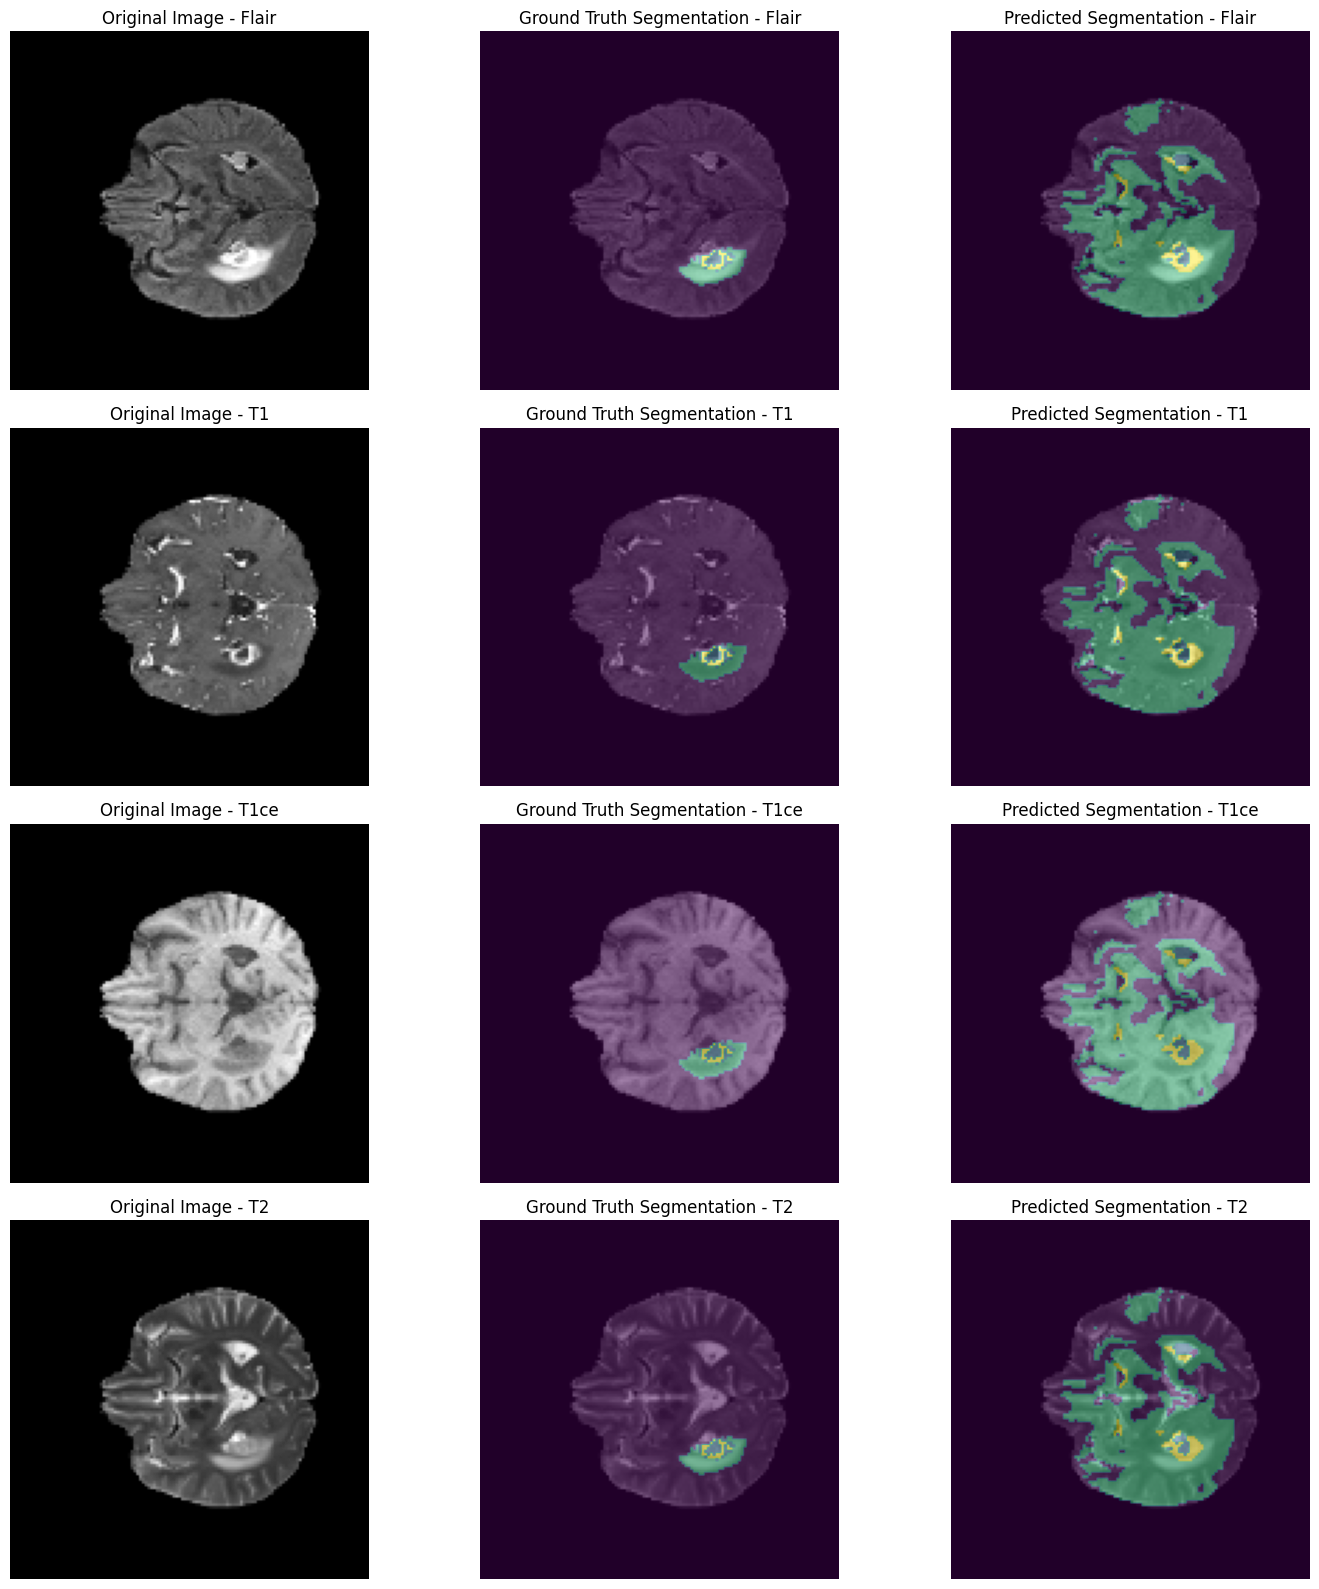

In [43]:
# Convert the test_generator to an iterator
test_iterator = iter(test_generator)

batch_number = random.randint(0,120)
print(batch_number)
X_test, y_true = test_generator.__getitem__(batch_number)

# Predict the segmentation masks for the test images
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_true, axis=-1)

# Plot the results
plot_segmentation_results(X_test, y_true_labels, y_pred_labels,num_images=1)


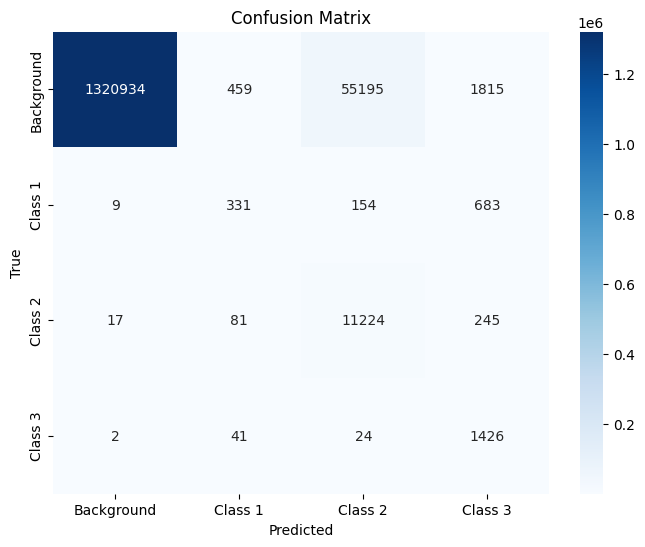

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Flatten the true and predicted labels
y_true_flat = np.argmax(y_true, axis=-1).flatten()
y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2, 3])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Background', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
from sklearn.metrics import classification_report, jaccard_score, precision_score, recall_score, f1_score

class_names = ['Background', 'Class 1', 'Class 2', 'Class 3']


# Initialize lists to hold per-class metrics
precision = []
recall = []
specificity = []
f1 = []
iou = []
dice = []

num_classes = len(labels)

for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    # Calculate precision, recall, specificity, F1-score, IoU, Dice coefficient
    precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0 
    specificity_i = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_i = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    iou_i = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0  
    dice_i = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0 
    
    # Append to lists
    precision.append(precision_i)
    recall.append(recall_i)
    specificity.append(specificity_i)
    f1.append(f1_i)
    iou.append(iou_i)
    dice.append(dice_i)


metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'Specificity': specificity,
    'F1-score': f1,
    'IoU': iou,
    'Dice Coefficient': dice
})

print("Per-Class Metrics:")
print(metrics_df)

Per-Class Metrics:
        Class  Precision    Recall  Specificity  F1-score       IoU  \
0  Background   0.999979  0.958308     0.998033  0.978700  0.958288   
1     Class 1   0.362939  0.281223     0.999582  0.316898  0.188282   
2     Class 2   0.168536  0.970347     0.959906  0.287191  0.167673   
3     Class 3   0.342048  0.955124     0.998028  0.503709  0.336638   

   Dice Coefficient  
0          0.978700  
1          0.316898  
2          0.287191  
3          0.503709  
